## Deep Learning Coding Project 2: Image Classification

Before we start, please put your **Chinese** name and student ID in following format:

Name, 0000000000 // e.g.) 傅炜, 2021123123

YOUR ANSWER HERE

## Introduction

We will use Python 3, [NumPy](https://numpy.org/), and [PyTorch](https://pytorch.org/) for this coding project. The example code has been tested under the latest stable release version.

### Task

In this notebook, you need to train a model to classify images. Given an image, you need to distinguish its category,
e.g., whether it is a horse or an automobile. There are total 10 classes:
airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. We
release 40,000 images for training, 10,000 images for validation. Each image has
a shape of (3, 128, 128). We will evaluate your model in 10,000 images on the test set.

Download the dataset from [here](https://cloud.tsinghua.edu.cn/d/00e0704738e04d32978b/) and organize them into a folder named "cifar_10_4x".

<!-- Images can be classified as "No Finding" or **one or more types**. In the basic task, given an image, you only need to tell whether the X-ray indicates "Infiltration". In the bonus task, you need to tell whether *each* of the diseases exists.

Images are taken from the [ChestX-ray14 dataset](https://www.kaggle.com/nih-chest-xrays/data) and downsampled to (256, 256). We release 44872 gray scale images for training and validation. We will evaluate your model on 10285 images in the test set. The dataset is available [here](https://cloud.tsinghua.edu.cn/d/16d06a89c5b4459db703/) and organized as follows: `train` directory includes all images for training and validation, and each line of `train.txt` records the labels separated by "|". -->

### Coding

We provide a code template. You can add new cells and modify our example to train your own model. To run this code, you should:

+ implement your model (named `Net`) in `model.py`.
+ implement your training loop in this notebook

Your final submitted model should not be larger than **20M**. **Using any pretrained model is NOT permitted**.
Besides, before you submit your result, **make sure you can test your model using our evaluation cell.** Name your best model "cifar10_4x_best.pth".

### Report & Submission

Your report should include:

1. the details of your model
2. all the hyper-parameters
3. all the tricks or training techniques you use
4. the training curve of your submitted model.

Reporting additional ablation studies and how you improve your model are also encouraged.

You should submit:

+ all codes
+ the model checkpoint (only "cifar10_4x_best.pth")
+ your report (a separate "pdf")

to web learning. We will use the evaluation code in this notebook to evaluate your model on the test set.

### Grading

We will grade this coding project based on the performance of your model (70%) and your report (30%). Regarding the evaluation metric of your model, assume your test accuracy is $X$, then your score is

$\frac{min(X,H)−0.6}{H−0.6}×7$

where $H$ is accuracy of the model trained by TAs and $H=0.9$, i.e., you will get the full score if your test accuracy is above 90%.

**Bonus**: The best submission with the highest testing accuracy will get 1 bonus point for the final course grade.

**Avoid plagiarism! Any student who violates academic integrity will be seriously dealt with and receive an F for the course.**

## Code Template

We have masked the the training loop in this notebook for you to complete. You should also overwrite "model.py" and implement your own model.

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Code

If you use Colab in this coding project, please uncomment the code, fill the `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` and run the following cells to mount your Google drive. Then, the notebook can find the required file. If you run the notebook locally, you can skip the following cells.

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import os

# # TODO: Fill in the Google Drive path where you uploaded the assignment
# # Example: If you create a 2022SP folder and put all the files under CP1 folder, then '2022SP/CP1'
# # GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2022SP/CP1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None 
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))

In [ ]:
# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
from dataset import CIFAR10_4x
from evaluation import evaluation

from model import Net  # this should be implemented by yourself

### Enjoy Your Coding Time!

In [ ]:
import math
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from PIL import Image


def set_seed(seed):
    seed = int(seed)
    if seed < 0 or seed > (2**32 - 1):
        raise ValueError("Seed must be between 0 and 2**32 - 1")
    else:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True


# Device configuration - optimized for cloud GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('='*60)
print(f'Using device: {device}')

if torch.cuda.is_available():
    print(f'GPU Name: {torch.cuda.get_device_name(0)}')
    print(f'GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')
    print(f'CUDA Version: {torch.version.cuda}')
    print(f'PyTorch Version: {torch.__version__}')
    # Enable cudnn benchmarking for better performance
    torch.backends.cudnn.benchmark = True
    print('cuDNN benchmark enabled for optimal performance')
else:
    print('WARNING: CUDA not available! Running on CPU.')
    print('Make sure GPU is enabled in your runtime settings.')
print('='*60)

set_seed(16)

In [ ]:
data_root_dir = '.'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([125 / 255, 124 / 255, 115 / 255],
                         [60 / 255, 59 / 255, 64 / 255])
])

# GPU-optimized DataLoader settings
# Use multiple workers (7 vCPU available) and pin memory for faster data transfer to GPU
num_workers = 4 if device == 'cuda' else 0
pin_memory = True if device == 'cuda' else False
batch_size_train = 64 if device == 'cuda' else 32  # Larger batch size for GPU with 16GB memory
batch_size_val = 256 if device == 'cuda' else 128

print(f'DataLoader config: num_workers={num_workers}, pin_memory={pin_memory}')
print(f'Batch sizes: train={batch_size_train}, validation={batch_size_val}')

trainset = CIFAR10_4x(root=data_root_dir,
                      split="train", transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, 
    num_workers=num_workers, pin_memory=pin_memory)

validset = CIFAR10_4x(root=data_root_dir,
                      split='valid', transform=transform)
validloader = torch.utils.data.DataLoader(
    validset, batch_size=batch_size_val, shuffle=False, 
    num_workers=num_workers, pin_memory=pin_memory)

net = Net()
print("number of trained parameters: %d" % (
    sum([param.nelement() for param in net.parameters() if param.requires_grad])))
print("number of total parameters: %d" %
      (sum([param.nelement() for param in net.parameters()])))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

net.to(device)
if device == 'cuda':
    print(f'✓ Model successfully moved to GPU: {torch.cuda.get_device_name(0)}')

number of trained parameters: 48938
number of total parameters: 48938


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(12, 16, kernel_size=(5, 5), stride=(3, 3))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
model_dir = '.'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
torch.save(net, os.path.join(model_dir, 'cifar10_4x_0.pth'))

# check the model size
os.system(' '.join(['du', '-h', os.path.join(model_dir, 'cifar10_4x_0.pth')]))

1

In [ ]:
# Helper functions for tracking best model across multiple training runs
import json
from datetime import datetime

def load_best_accuracy():
    """Load the best accuracy from previous training runs"""
    history_file = 'training_history.txt'
    try:
        if os.path.exists(history_file):
            with open(history_file, 'r') as f:
                lines = f.readlines()
                for line in reversed(lines):
                    if 'Validation Accuracy:' in line:
                        acc_str = line.split(':')[1].strip().replace('%', '')
                        return float(acc_str)
    except:
        pass
    return 0.0

def save_training_record(val_acc, hyperparams, notes=""):
    """Save training run information to history file"""
    history_file = 'training_history.txt'
    
    # Count existing runs
    run_number = 1
    if os.path.exists(history_file):
        with open(history_file, 'r') as f:
            content = f.read()
            run_number = content.count('Training Run #') + 1
    
    # Append new record
    with open(history_file, 'a') as f:
        f.write(f"\nTraining Run #{run_number}\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Validation Accuracy: {val_acc:.2f}%\n")
        f.write(f"Hyperparameters:\n")
        for key, value in hyperparams.items():
            f.write(f"  - {key}: {value}\n")
        if notes:
            f.write(f"Notes: {notes}\n")
        f.write("-" * 52 + "\n")
    
    print(f"\n✓ Training record saved to {history_file}")

# Load best accuracy from previous runs
global_best_accuracy = load_best_accuracy()
print(f"Best accuracy from previous runs: {global_best_accuracy:.2f}%")

In [24]:
# You can adjust these hyperparameters before training
num_epochs = 50  # Set to smaller number like 5 or 10 for quick testing
learning_rate = 5e-3
batch_size = 32

# Update optimizer with new learning rate if needed
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
def train():
    ##############################################################################
    #                  TODO: You need to complete the code here                  #
    ##############################################################################
    # YOUR CODE HERE
    best_val_acc = 0.0
    train_losses = []
    train_accs = []
    val_accs = []
    
    # Check if we need to beat a previous record
    print(f"\n{'='*60}")
    print(f"Global best accuracy to beat: {global_best_accuracy:.2f}%")
    print(f"{'='*60}\n")
    
    try:
        for epoch in range(num_epochs):
            # Training phase
            net.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for i, (inputs, labels) in enumerate(trainloader):
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                # Statistics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                if (i + 1) % 100 == 0:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                          f'Loss: {running_loss/(i+1):.4f}, Acc: {100.*correct/total:.2f}%')
            
            train_loss = running_loss / len(trainloader)
            train_acc = 100. * correct / total
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            # Validation phase
            net.eval()
            correct = 0
            total = 0
            
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = net(inputs)
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
            
            val_acc = 100. * correct / total
            val_accs.append(val_acc)
            
            print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
            
            # Save the best model in this training run
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                # Only save if it beats the global best
                if best_val_acc > global_best_accuracy:
                    torch.save(net, os.path.join(model_dir, 'cifar10_4x_best.pth'))
                    print(f'🎉 NEW RECORD! Model saved with validation accuracy: {best_val_acc:.2f}%')
                else:
                    print(f'Best in current run: {best_val_acc:.2f}% (Global best: {global_best_accuracy:.2f}%)')
            
            # Save checkpoint every 10 epochs
            if (epoch + 1) % 10 == 0:
                torch.save(net, os.path.join(model_dir, f'cifar10_4x_{epoch+1}.pth'))
    
    except KeyboardInterrupt:
        print('\n' + '='*50)
        print('Training interrupted by user!')
        if best_val_acc > 0:
            print(f'Best validation accuracy so far: {best_val_acc:.2f}%')
            if best_val_acc > global_best_accuracy:
                print(f'✓ Model saved at: {os.path.join(model_dir, "cifar10_4x_best.pth")}')
        else:
            print('No completed epochs yet - no model saved.')
        print(f'Completed {len(train_losses)} epochs before interruption.')
        print('='*50)
    
    # Plot training curves (only if we have data)
    if len(train_losses) > 0:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.title('Training Loss Curve')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(model_dir, 'training_curves.png'))
        plt.show()
        
        print(f'\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%')
        print(f'\nnum_epochs:{num_epochs}')
        print(f'\nlearning_rate:{learning_rate:.4f}')
        print(f'\nbatch_size:{batch_size}')
        
        # Save training record with hyperparameters
        hyperparams = {
            'num_epochs': num_epochs,
            'learning_rate': learning_rate,
            'batch_size': batch_size_train if device == 'cuda' else batch_size,
            'optimizer': type(optimizer).__name__,
            'criterion': type(criterion).__name__,
            'device': device,
            'final_train_acc': f'{train_accs[-1]:.2f}%',
            'final_val_acc': f'{val_accs[-1]:.2f}%',
        }
        
        # Determine if this is a new record
        if best_val_acc > global_best_accuracy:
            notes = f"🎉 NEW RECORD! Improved from {global_best_accuracy:.2f}% to {best_val_acc:.2f}%"
        else:
            notes = f"Did not beat global best ({global_best_accuracy:.2f}%)"
        
        save_training_record(best_val_acc, hyperparams, notes)
    else:
        print('\nNo completed epochs - no training curves to plot.')
    ##############################################################################
    #                              END OF YOUR CODE                              #
    ##############################################################################

Epoch [1/50], Step [100/1250], Loss: 1.1991, Acc: 59.00%
Epoch [1/50], Step [200/1250], Loss: 1.1444, Acc: 60.67%
Epoch [1/50], Step [200/1250], Loss: 1.1444, Acc: 60.67%
Epoch [1/50], Step [300/1250], Loss: 1.1611, Acc: 59.82%
Epoch [1/50], Step [300/1250], Loss: 1.1611, Acc: 59.82%
Epoch [1/50], Step [400/1250], Loss: 1.1842, Acc: 58.87%
Epoch [1/50], Step [400/1250], Loss: 1.1842, Acc: 58.87%
Epoch [1/50], Step [500/1250], Loss: 1.1894, Acc: 58.53%
Epoch [1/50], Step [500/1250], Loss: 1.1894, Acc: 58.53%
Epoch [1/50], Step [600/1250], Loss: 1.1870, Acc: 58.60%
Epoch [1/50], Step [600/1250], Loss: 1.1870, Acc: 58.60%
Epoch [1/50], Step [700/1250], Loss: 1.1944, Acc: 58.31%
Epoch [1/50], Step [700/1250], Loss: 1.1944, Acc: 58.31%
Epoch [1/50], Step [800/1250], Loss: 1.1994, Acc: 58.12%
Epoch [1/50], Step [800/1250], Loss: 1.1994, Acc: 58.12%
Epoch [1/50], Step [900/1250], Loss: 1.2061, Acc: 57.91%
Epoch [1/50], Step [900/1250], Loss: 1.2061, Acc: 57.91%
Epoch [1/50], Step [1000/1250],

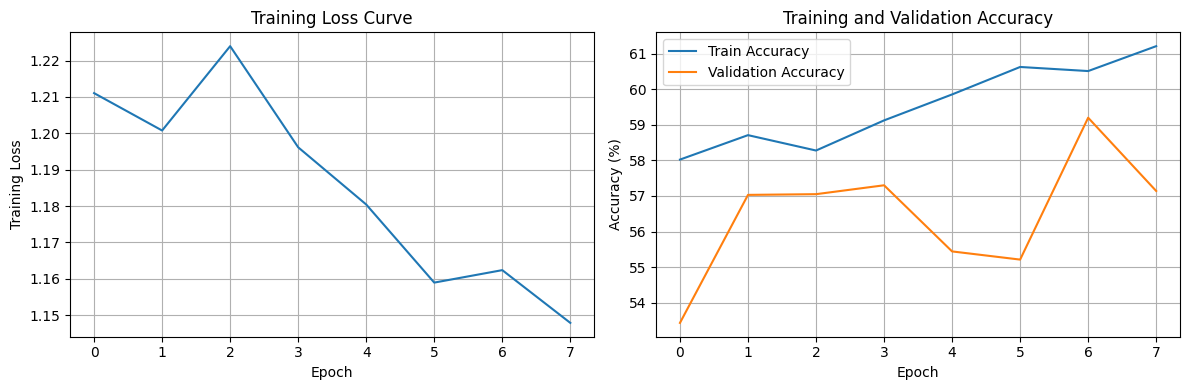


Training completed! Best validation accuracy: 59.20%


In [25]:
# Start training
train()

## Evaluation

Before submission, please run the following cell to make sure your model can be correctly graded.

In [23]:
!python evaluation.py

Traceback (most recent call last):
  File "d:\Course Materials\Courses_For_Developing\Deep_Learning-Wu Yi\CodingProject2\CodingProject2\evaluation.py", line 34, in <module>
    net = torch.load(os.path.join(base_dir, "models/cifar10_4x_best.pth"))
  File "c:\Users\Eric_J\anaconda3\envs\data-analysis\lib\site-packages\torch\serialization.py", line 1479, in load
    with _open_file_like(f, "rb") as opened_file:
  File "c:\Users\Eric_J\anaconda3\envs\data-analysis\lib\site-packages\torch\serialization.py", line 759, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "c:\Users\Eric_J\anaconda3\envs\data-analysis\lib\site-packages\torch\serialization.py", line 740, in __init__
    super().__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: 'd:\\Course Materials\\Courses_For_Developing\\Deep_Learning-Wu Yi\\CodingProject2\\CodingProject2\\models/cifar10_4x_best.pth'
